In [1]:
import numpy as np
import pandas as pd
from joblib import dump, load
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
import time

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (StandardScaler, OneHotEncoder)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import (NearestNeighbors, NeighborhoodComponentsAnalysis, KNeighborsClassifier)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.model_selection import (GridSearchCV, cross_val_score)
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split

In [2]:
# data path

# Windows
ROOT = "C:/Users/weiru/OneDrive - University of Leeds/MSc-Lab/datasets"

#Mac
# ROOT = "/Users/cccc/OneDrive - University of Leeds/MSc-Lab/datasets"

dataPath = ROOT + "/files/dataset1PTHuse1_400.csv"

In [3]:
# load data
df = pd.read_csv(dataPath)

In [4]:
df

,Patient,PTH,Ca,Vit D,Mg,eGFR,Interpretation
0,1,1.1,1.90,72.0,0.1,80,A1
1,2,15.4,2.85,90.0,0.9,66,I
2,3,0.7,1.70,89.0,1.0,90,A2
3,4,2.3,1.90,60.0,0.1,80,B1
4,5,12.2,1.70,32.0,1.0,90,C1
...,...,...,...,...,...,...,...
395,396,15.4,2.85,90.0,0.9,66,I
396,397,0.7,1.70,89.0,1.0,90,A2
397,398,2.3,1.90,60.0,0.1,80,B1
398,399,12.2,1.70,32.0,1.0,90,C1


In [5]:
# Delete Patitent column

df = df.drop(columns=['Patient']).copy()

In [6]:
df

,PTH,Ca,Vit D,Mg,eGFR,Interpretation
0,1.1,1.90,72.0,0.1,80,A1
1,15.4,2.85,90.0,0.9,66,I
2,0.7,1.70,89.0,1.0,90,A2
3,2.3,1.90,60.0,0.1,80,B1
4,12.2,1.70,32.0,1.0,90,C1
...,...,...,...,...,...,...
395,15.4,2.85,90.0,0.9,66,I
396,0.7,1.70,89.0,1.0,90,A2
397,2.3,1.90,60.0,0.1,80,B1
398,12.2,1.70,32.0,1.0,90,C1


In [7]:
class ExpReplaceValues():
    
    def __init__(self):
        pass
        
    def imputedDF(self, df, strategy):
    
        fill_NaN           = SimpleImputer(strategy=strategy)
        df_attr            = df.iloc[:,:-1]

        imputed_DF         = pd.DataFrame(fill_NaN.fit_transform(df_attr))
        imputed_DF.columns = df_attr.columns
        imputed_DF.index   = df_attr.index

        new_df             = imputed_DF.join(df.iloc[:,-1])

        return new_df
    
    
    
    def normalizedDF(self, df):
        normalized            = MinMaxScaler()
        df_attr               = df.iloc[:,:-1]
        normalized_DF         = pd.DataFrame(normalized.fit_transform(df_attr))
        normalized_DF.columns = df_attr.columns
        normalized_DF.index   = df_attr.index
        new_df                = normalized_DF.join(df.iloc[:,-1])
        return new_df
    
    
    
    def standardDF(self, df):
        std_scale      = StandardScaler()
        df_attr        = df.iloc[:,:-1]
        std_DF         = pd.DataFrame(std_scale.fit_transform(df_attr))
        std_DF.columns = df_attr.columns
        std_DF.index   = df_attr.index
        new_df         = std_DF.join(df.iloc[:,-1])
        return new_df
    
    
    
    def checkIsNull(self, df):
        '''
            Check whether the dataframe has nulls
        '''
        if df.isnull().values.any():
            print("Data have nulls")
        else:
            print("Data don't have nulls")
        
        
        
    def pipe(self, CA=""):
        
        RANDOM_STATE = 42
        knn          = KNeighborsClassifier()
        pca          = PCA(random_state=RANDOM_STATE)
        lda          = LinearDiscriminantAnalysis()
        nca          = NeighborhoodComponentsAnalysis(random_state=RANDOM_STATE)
        
        knn_pipe     = Pipeline([('knn', knn)])
        pca_pipe     = Pipeline([('pca', pca), ('knn', knn)])
        lda_pipe     = Pipeline([('lda', lda), ('knn', knn)])
        nca_pipe     = Pipeline([('nca', nca), ('knn', knn)])
        
        if CA == 'pca':
            return pca_pipe
        if CA == 'lda':
            return lda_pipe
        if CA == 'nca':
            return nca_pipe
        
        return knn_pipe
    
    
    
    def trainAndTarg(self, df):
    
        attri  = df.iloc[:,:-1]
        target = df.iloc[:, -1]

        return attri,target
    
    
    
    def print_best_param(self, clf_fit):
        print('Best score : ', clf_fit.best_score_)
        print('Best parameters', clf_fit.best_params_)
        
        
    
    def search__best_param(self, df, pipe, algorithm='brute', distance='manhattan', p=False):
        grid_params = {
            'knn__n_neighbors' : [i for i in range(2,40)],
            'knn__weights'     : ['distance'],
            'knn__algorithm'   : [algorithm], # ball_tree, kd_tree, brute
            'knn__metric'      : [distance],  # manhattan, euclidean, chebyshev
        }

        clf = GridSearchCV(
            pipe,
            grid_params,
            cv=8,
            n_jobs=-1
        )
        
        attri, target = self.trainAndTarg(df)
        clf_fit = clf.fit(attri, target)

        # print parameter
        if p is True:
            self.print_best_param(clf_fit)

        return clf_fit

In [8]:
E1 = ExpReplaceValues()

**replace missed values**

In [9]:
def runExp1_1(df, strategy):
    replaced_df   = E1.imputedDF(df, strategy)
    knn_pipe      = E1.pipe()
    distances     = ['manhattan', 'euclidean', 'chebyshev']
    for d in distances:
        E1.search__best_param(df=replaced_df, pipe=knn_pipe, distance=d, p=True)

In [10]:
runExp1_1(df, 'mean')

Best score :  0.645
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'manhattan', 'knn__n_neighbors': 2, 'knn__weights': 'distance'}
Best score :  0.6325
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'euclidean', 'knn__n_neighbors': 2, 'knn__weights': 'distance'}
Best score :  0.61
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 2, 'knn__weights': 'distance'}


In [11]:
runExp1_1(df, 'median')

Best score :  0.6325
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}
Best score :  0.6174999999999999
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'euclidean', 'knn__n_neighbors': 2, 'knn__weights': 'distance'}
Best score :  0.5974999999999999
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 2, 'knn__weights': 'distance'}


In [12]:
runExp1_1(df, 'most_frequent')

Best score :  0.6425
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}
Best score :  0.615
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'euclidean', 'knn__n_neighbors': 2, 'knn__weights': 'distance'}
Best score :  0.595
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 2, 'knn__weights': 'distance'}


**replace missed values + normalized**

In [13]:
def runExp1_2_1(df, strategy):
    replaced_df   = E1.imputedDF(df, strategy)
    norm_df       = E1.normalizedDF(replaced_df)
    knn_pipe      = E1.pipe()
    distances     = ['manhattan', 'euclidean', 'chebyshev']
    for d in distances:
        E1.search__best_param(df=norm_df, pipe=knn_pipe, distance=d, p=True)

In [14]:
runExp1_2_1(df, 'mean')

Best score :  0.8099999999999999
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'manhattan', 'knn__n_neighbors': 2, 'knn__weights': 'distance'}
Best score :  0.7875000000000001
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'euclidean', 'knn__n_neighbors': 2, 'knn__weights': 'distance'}
Best score :  0.7675000000000001
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 2, 'knn__weights': 'distance'}


In [15]:
runExp1_2_1(df, 'median')

Best score :  0.8025
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'manhattan', 'knn__n_neighbors': 2, 'knn__weights': 'distance'}
Best score :  0.78
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'euclidean', 'knn__n_neighbors': 2, 'knn__weights': 'distance'}
Best score :  0.7625
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 2, 'knn__weights': 'distance'}


In [16]:
runExp1_2_1(df, 'most_frequent')

Best score :  0.795
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}
Best score :  0.775
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'euclidean', 'knn__n_neighbors': 2, 'knn__weights': 'distance'}
Best score :  0.75
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 2, 'knn__weights': 'distance'}


**replace missed values + standard**

In [17]:
def runExp1_2_2(df, strategy):
    replaced_df   = E1.imputedDF(df, strategy)
    std_df        = E1.standardDF(replaced_df)
    knn_pipe      = E1.pipe()
    distances     = ['manhattan', 'euclidean', 'chebyshev']
    for d in distances:
        E1.search__best_param(df=std_df, pipe=knn_pipe, distance=d, p=True)

In [18]:
runExp1_2_2(df, 'mean')

Best score :  0.8125
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'manhattan', 'knn__n_neighbors': 14, 'knn__weights': 'distance'}
Best score :  0.7725
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'euclidean', 'knn__n_neighbors': 2, 'knn__weights': 'distance'}
Best score :  0.76
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 4, 'knn__weights': 'distance'}


In [19]:
runExp1_2_2(df, 'median')

Best score :  0.8125
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'manhattan', 'knn__n_neighbors': 16, 'knn__weights': 'distance'}
Best score :  0.7725
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'euclidean', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}
Best score :  0.7575000000000001
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 4, 'knn__weights': 'distance'}


In [20]:
runExp1_2_2(df, 'most_frequent')

Best score :  0.8075
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'manhattan', 'knn__n_neighbors': 13, 'knn__weights': 'distance'}
Best score :  0.7775000000000001
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'euclidean', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}
Best score :  0.7575000000000001
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 4, 'knn__weights': 'distance'}


In [21]:
def runExp1_3(df, strategy, CA):
    replaced_df   = E1.imputedDF(df, strategy)
    std_df        = E1.standardDF(replaced_df)
#     
    pipe      = E1.pipe(CA)
    distances     = ['manhattan', 'euclidean', 'chebyshev']
    for d in distances:
        E1.search__best_param(df=std_df, pipe=pipe, distance=d, p=True)

In [22]:
runExp1_3(df, 'median', 'pca')

Best score :  0.7775000000000001
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'manhattan', 'knn__n_neighbors': 6, 'knn__weights': 'distance'}
Best score :  0.7725
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'euclidean', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}
Best score :  0.775
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 2, 'knn__weights': 'distance'}


In [23]:
runExp1_3(df, 'mean', 'pca')

Best score :  0.78
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}
Best score :  0.7725
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'euclidean', 'knn__n_neighbors': 2, 'knn__weights': 'distance'}
Best score :  0.7875
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 2, 'knn__weights': 'distance'}


In [24]:
runExp1_3(df, 'most_frequent', 'pca')

Best score :  0.78
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'manhattan', 'knn__n_neighbors': 4, 'knn__weights': 'distance'}
Best score :  0.7775000000000001
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'euclidean', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}
Best score :  0.7725
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 2, 'knn__weights': 'distance'}


In [25]:
runExp1_3(df, 'median', 'lda')

Best score :  0.845
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'manhattan', 'knn__n_neighbors': 11, 'knn__weights': 'distance'}
Best score :  0.8300000000000001
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'euclidean', 'knn__n_neighbors': 16, 'knn__weights': 'distance'}
Best score :  0.7949999999999999
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 10, 'knn__weights': 'distance'}


In [26]:
runExp1_3(df, 'mean', 'lda')

Best score :  0.845
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'manhattan', 'knn__n_neighbors': 11, 'knn__weights': 'distance'}
Best score :  0.8325
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'euclidean', 'knn__n_neighbors': 15, 'knn__weights': 'distance'}
Best score :  0.795
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 10, 'knn__weights': 'distance'}


In [27]:
runExp1_3(df, 'most_frequent', 'lda')

Best score :  0.8500000000000001
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'manhattan', 'knn__n_neighbors': 14, 'knn__weights': 'distance'}
Best score :  0.825
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'euclidean', 'knn__n_neighbors': 14, 'knn__weights': 'distance'}
Best score :  0.78
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 6, 'knn__weights': 'distance'}


In [28]:
runExp1_3(df, 'median', 'nca')

Best score :  0.8450000000000001
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'manhattan', 'knn__n_neighbors': 5, 'knn__weights': 'distance'}
Best score :  0.8350000000000001
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'euclidean', 'knn__n_neighbors': 6, 'knn__weights': 'distance'}
Best score :  0.8275
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 8, 'knn__weights': 'distance'}


In [29]:
runExp1_3(df, 'mean', 'nca')

Best score :  0.8225
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'manhattan', 'knn__n_neighbors': 5, 'knn__weights': 'distance'}
Best score :  0.825
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'euclidean', 'knn__n_neighbors': 5, 'knn__weights': 'distance'}
Best score :  0.81
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 4, 'knn__weights': 'distance'}


In [30]:
runExp1_3(df, 'most_frequent', 'nca')

Best score :  0.8325
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'manhattan', 'knn__n_neighbors': 5, 'knn__weights': 'distance'}
Best score :  0.8375
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'euclidean', 'knn__n_neighbors': 11, 'knn__weights': 'distance'}
Best score :  0.835
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 11, 'knn__weights': 'distance'}


#### Experment 1 Summary

The best result is `runExp1_3(df, 'most_frequent', 'lda')`

AUC is 0.85

In [31]:
class ExpDeleteNulls(ExpReplaceValues):
    def __init__(self):
        super(ExpDeleteNulls, self)
    
    def removeNull(self, df):
        nonNull_df = df.copy()
        nonNull_df = nonNull_df.dropna(how='any',axis=0)
        return nonNull_df 

In [32]:
E2 = ExpDeleteNulls()

In [33]:
def runExp2_1(df, CA):
    nonNull_df    = E2.removeNull(df)
    std_df        = E2.standardDF(nonNull_df)
    pipe          = E2.pipe(CA)
    distances     = ['manhattan', 'euclidean', 'chebyshev']
    clfs          = []
    for d in distances:
        clfs.append(E1.search__best_param(df=std_df, pipe=pipe, distance=d, p=True))

    return clfs

In [34]:
std_result_knn = runExp2_1(df,"")

Best score :  0.846322849213691
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'manhattan', 'knn__n_neighbors': 14, 'knn__weights': 'distance'}
Best score :  0.8140032377428308
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'euclidean', 'knn__n_neighbors': 12, 'knn__weights': 'distance'}
Best score :  0.8166628122109159
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 4, 'knn__weights': 'distance'}


In [35]:
std_result_pca = runExp2_1(df, 'pca')

Best score :  0.8381706753006475
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}
Best score :  0.8140032377428308
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'euclidean', 'knn__n_neighbors': 12, 'knn__weights': 'distance'}
Best score :  0.8248149861239593
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 6, 'knn__weights': 'distance'}


In [36]:
std_result_lda = runExp2_1(df, 'lda')

Best score :  0.8947733580018502
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'manhattan', 'knn__n_neighbors': 11, 'knn__weights': 'distance'}
Best score :  0.8733811285846438
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'euclidean', 'knn__n_neighbors': 9, 'knn__weights': 'distance'}
Best score :  0.8491558741905643
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 7, 'knn__weights': 'distance'}


In [37]:
std_result_nca = runExp2_1(df, 'nca')

Best score :  0.8841350601295097
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'manhattan', 'knn__n_neighbors': 6, 'knn__weights': 'distance'}
Best score :  0.8895120259019427
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'euclidean', 'knn__n_neighbors': 6, 'knn__weights': 'distance'}
Best score :  0.8813598519888992
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 8, 'knn__weights': 'distance'}


In [38]:
def runExp2_2(df, CA):
    nonNull_df    = E2.removeNull(df)
    norm_df       = E2.normalizedDF(nonNull_df)
    pipe          = E2.pipe(CA)
    distances     = ['manhattan', 'euclidean', 'chebyshev']
    clfs          = []
    for d in distances:
        clfs.append(E1.search__best_param(df=norm_df, pipe=pipe, distance=d, p=True))

    return clfs

In [39]:
# normialized + knn
norm_result_knn = runExp2_2(df, '')

Best score :  0.8331406105457909
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}
Best score :  0.8275901942645698
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'euclidean', 'knn__n_neighbors': 2, 'knn__weights': 'distance'}
Best score :  0.795386216466235
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 2, 'knn__weights': 'distance'}


In [40]:
# pca + knn
norm_result_pca = runExp2_2(df, 'pca')

Best score :  0.8220397779833487
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}
Best score :  0.8275901942645698
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'euclidean', 'knn__n_neighbors': 2, 'knn__weights': 'distance'}
Best score :  0.8089731729879741
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}


In [41]:
# lda + knn
norm_result_lda = runExp2_2(df, 'lda')

Best score :  0.8947733580018502
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'manhattan', 'knn__n_neighbors': 11, 'knn__weights': 'distance'}
Best score :  0.8733811285846438
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'euclidean', 'knn__n_neighbors': 9, 'knn__weights': 'distance'}
Best score :  0.8491558741905643
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 7, 'knn__weights': 'distance'}


In [42]:
# nca + knn
norm_result_nca = runExp2_2(df, 'nca')

Best score :  0.8653445883441258
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'manhattan', 'knn__n_neighbors': 6, 'knn__weights': 'distance'}
Best score :  0.8704902867715079
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'euclidean', 'knn__n_neighbors': 13, 'knn__weights': 'distance'}
Best score :  0.8572502312673451
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 4, 'knn__weights': 'distance'}


In [43]:
def runExp2_3(df, CA):
    nonNull_df    = E2.removeNull(df)
    pipe          = E2.pipe(CA)
    distances     = ['manhattan', 'euclidean', 'chebyshev']
    clfs          = []
    for d in distances:
        clfs.append(E1.search__best_param(df=nonNull_df, pipe=pipe, distance=d, p=True))

    return clfs

In [44]:
result_knn = runExp2_3(df, '')

Best score :  0.6656452358926919
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'manhattan', 'knn__n_neighbors': 2, 'knn__weights': 'distance'}
Best score :  0.6492252543940795
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'euclidean', 'knn__n_neighbors': 2, 'knn__weights': 'distance'}
Best score :  0.6356382978723404
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 2, 'knn__weights': 'distance'}


In [45]:
result_pca = runExp2_3(df, 'pca')

Best score :  0.6601526364477335
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'manhattan', 'knn__n_neighbors': 2, 'knn__weights': 'distance'}
Best score :  0.6492252543940795
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'euclidean', 'knn__n_neighbors': 2, 'knn__weights': 'distance'}
Best score :  0.638413506012951
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 2, 'knn__weights': 'distance'}


In [46]:
result_lda = runExp2_3(df, 'lda')

Best score :  0.8947733580018502
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'manhattan', 'knn__n_neighbors': 11, 'knn__weights': 'distance'}
Best score :  0.8733811285846438
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'euclidean', 'knn__n_neighbors': 9, 'knn__weights': 'distance'}
Best score :  0.8491558741905643
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 7, 'knn__weights': 'distance'}


In [47]:
result_nca = runExp2_3(df, 'nca')

Best score :  0.8244680851063829
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'manhattan', 'knn__n_neighbors': 6, 'knn__weights': 'distance'}
Best score :  0.8379394079555967
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'euclidean', 'knn__n_neighbors': 6, 'knn__weights': 'distance'}
Best score :  0.8435476410730806
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 6, 'knn__weights': 'distance'}


**two good result** 
1. `std_result_lda = runExp2_1(df, 'lda')`
2. `std_result_nca = runExp2_1(df, 'nca')`

In [48]:
def runExp3_1(df, algorithm, CA):
    nonNull_df    = E2.removeNull(df)
    std_df        = E2.standardDF(nonNull_df)
    pipe          = E2.pipe(CA)
    distances     = ['manhattan', 'euclidean', 'chebyshev']
    clfs          = []
    _time         = []
    
    for d in distances:
        start_time = time.time()
        clfs.append(E1.search__best_param(df=std_df, algorithm=algorithm, pipe=pipe, distance=d, p=True))
        end_time   = time.time()
        _time.append(end_time-start_time)
        
    print("avge time is ", np.mean(_time))
    
    return clfs

In [49]:
brute_knn = runExp3_1(df, 'brute', '')

Best score :  0.846322849213691
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'manhattan', 'knn__n_neighbors': 14, 'knn__weights': 'distance'}
Best score :  0.8140032377428308
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'euclidean', 'knn__n_neighbors': 12, 'knn__weights': 'distance'}
Best score :  0.8166628122109159
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 4, 'knn__weights': 'distance'}
avge time is  0.21947630246480307


In [50]:
brute_pca = runExp3_1(df, 'brute', 'pca')

Best score :  0.8381706753006475
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}
Best score :  0.8140032377428308
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'euclidean', 'knn__n_neighbors': 12, 'knn__weights': 'distance'}
Best score :  0.8248149861239593
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 6, 'knn__weights': 'distance'}
avge time is  0.2429027557373047


In [51]:
brute_lda = runExp3_1(df, 'brute', 'lda')

Best score :  0.8947733580018502
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'manhattan', 'knn__n_neighbors': 11, 'knn__weights': 'distance'}
Best score :  0.8733811285846438
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'euclidean', 'knn__n_neighbors': 9, 'knn__weights': 'distance'}
Best score :  0.8491558741905643
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 7, 'knn__weights': 'distance'}
avge time is  0.3033449649810791


In [52]:
brute_nca = runExp3_1(df, 'brute', 'nca')

Best score :  0.8841350601295097
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'manhattan', 'knn__n_neighbors': 6, 'knn__weights': 'distance'}
Best score :  0.8895120259019427
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'euclidean', 'knn__n_neighbors': 6, 'knn__weights': 'distance'}
Best score :  0.8813598519888992
Best parameters {'knn__algorithm': 'brute', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 8, 'knn__weights': 'distance'}
avge time is  10.714478333791098


In [53]:
kd_knn = runExp3_1(df, 'kd_tree', '')

Best score :  0.846322849213691
Best parameters {'knn__algorithm': 'kd_tree', 'knn__metric': 'manhattan', 'knn__n_neighbors': 14, 'knn__weights': 'distance'}
Best score :  0.8140032377428308
Best parameters {'knn__algorithm': 'kd_tree', 'knn__metric': 'euclidean', 'knn__n_neighbors': 12, 'knn__weights': 'distance'}
Best score :  0.8140032377428307
Best parameters {'knn__algorithm': 'kd_tree', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 4, 'knn__weights': 'distance'}
avge time is  0.20807592074076334


In [54]:
kd_pda = runExp3_1(df, 'kd_tree', 'pca')

Best score :  0.8381706753006475
Best parameters {'knn__algorithm': 'kd_tree', 'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}
Best score :  0.8140032377428308
Best parameters {'knn__algorithm': 'kd_tree', 'knn__metric': 'euclidean', 'knn__n_neighbors': 12, 'knn__weights': 'distance'}
Best score :  0.8248149861239593
Best parameters {'knn__algorithm': 'kd_tree', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 6, 'knn__weights': 'distance'}
avge time is  0.25751233100891113


In [55]:
kd_lda = runExp3_1(df, 'kd_tree', 'lda')

Best score :  0.8947733580018502
Best parameters {'knn__algorithm': 'kd_tree', 'knn__metric': 'manhattan', 'knn__n_neighbors': 11, 'knn__weights': 'distance'}
Best score :  0.8733811285846438
Best parameters {'knn__algorithm': 'kd_tree', 'knn__metric': 'euclidean', 'knn__n_neighbors': 9, 'knn__weights': 'distance'}
Best score :  0.8491558741905643
Best parameters {'knn__algorithm': 'kd_tree', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 7, 'knn__weights': 'distance'}
avge time is  0.31414445241292316


In [56]:
kd_nca = runExp3_1(df, 'kd_tree', 'nca')

Best score :  0.8841350601295097
Best parameters {'knn__algorithm': 'kd_tree', 'knn__metric': 'manhattan', 'knn__n_neighbors': 6, 'knn__weights': 'distance'}
Best score :  0.8895120259019427
Best parameters {'knn__algorithm': 'kd_tree', 'knn__metric': 'euclidean', 'knn__n_neighbors': 6, 'knn__weights': 'distance'}
Best score :  0.8813598519888992
Best parameters {'knn__algorithm': 'kd_tree', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 8, 'knn__weights': 'distance'}
avge time is  10.711554129918417


In [57]:
ball_knn = runExp3_1(df, 'ball_tree', '')

Best score :  0.846322849213691
Best parameters {'knn__algorithm': 'ball_tree', 'knn__metric': 'manhattan', 'knn__n_neighbors': 14, 'knn__weights': 'distance'}
Best score :  0.8140032377428308
Best parameters {'knn__algorithm': 'ball_tree', 'knn__metric': 'euclidean', 'knn__n_neighbors': 12, 'knn__weights': 'distance'}
Best score :  0.8167206290471785
Best parameters {'knn__algorithm': 'ball_tree', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 4, 'knn__weights': 'distance'}
avge time is  0.2048036257425944


In [58]:
ball_pca = runExp3_1(df, 'ball_tree', 'pca')

Best score :  0.8381706753006475
Best parameters {'knn__algorithm': 'ball_tree', 'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}
Best score :  0.8140032377428308
Best parameters {'knn__algorithm': 'ball_tree', 'knn__metric': 'euclidean', 'knn__n_neighbors': 12, 'knn__weights': 'distance'}
Best score :  0.8248149861239593
Best parameters {'knn__algorithm': 'ball_tree', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 6, 'knn__weights': 'distance'}
avge time is  0.2465968132019043


In [59]:
ball_lda = runExp3_1(df, 'ball_tree', 'lda')

Best score :  0.8947733580018502
Best parameters {'knn__algorithm': 'ball_tree', 'knn__metric': 'manhattan', 'knn__n_neighbors': 11, 'knn__weights': 'distance'}
Best score :  0.8733811285846438
Best parameters {'knn__algorithm': 'ball_tree', 'knn__metric': 'euclidean', 'knn__n_neighbors': 9, 'knn__weights': 'distance'}
Best score :  0.8491558741905643
Best parameters {'knn__algorithm': 'ball_tree', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 7, 'knn__weights': 'distance'}
avge time is  0.3087042172749837


In [60]:
ball_nca = runExp3_1(df, 'ball_tree', 'nca')

Best score :  0.8841350601295097
Best parameters {'knn__algorithm': 'ball_tree', 'knn__metric': 'manhattan', 'knn__n_neighbors': 6, 'knn__weights': 'distance'}
Best score :  0.8895120259019427
Best parameters {'knn__algorithm': 'ball_tree', 'knn__metric': 'euclidean', 'knn__n_neighbors': 6, 'knn__weights': 'distance'}
Best score :  0.8813598519888992
Best parameters {'knn__algorithm': 'ball_tree', 'knn__metric': 'chebyshev', 'knn__n_neighbors': 8, 'knn__weights': 'distance'}
avge time is  10.542190710703531


In [61]:
10.71/0.32

33.46875

### Evaluation

In [62]:
attri, target = E2.trainAndTarg(E2.removeNull(df))

In [63]:
clf = ball_lda[0]
clf.best_estimator_

Pipeline(steps=[('lda', LinearDiscriminantAnalysis()),
                ('knn',
                 KNeighborsClassifier(algorithm='ball_tree', metric='manhattan',
                                      n_neighbors=11, weights='distance'))])

In [64]:
scores = cross_val_score(clf.best_estimator_, attri, target, n_jobs=-1,cv=8, scoring='accuracy')
print(scores)
print('mean score : ', scores.mean())

[0.87234043 0.85106383 0.91304348 0.93478261 0.73913043 0.95652174
 0.91304348 0.97826087]
mean score :  0.8947733580018502


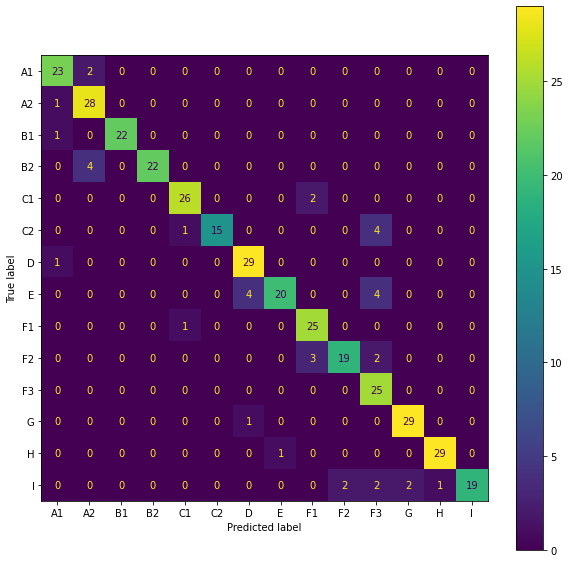

              precision    recall  f1-score   support

          A1       0.88      0.92      0.90        25
          A2       0.82      0.97      0.89        29
          B1       1.00      0.96      0.98        23
          B2       1.00      0.85      0.92        26
          C1       0.93      0.93      0.93        28
          C2       1.00      0.75      0.86        20
           D       0.85      0.97      0.91        30
           E       0.95      0.71      0.82        28
          F1       0.83      0.96      0.89        26
          F2       0.90      0.79      0.84        24
          F3       0.68      1.00      0.81        25
           G       0.94      0.97      0.95        30
           H       0.97      0.97      0.97        30
           I       1.00      0.73      0.84        26

    accuracy                           0.89       370
   macro avg       0.91      0.89      0.89       370
weighted avg       0.91      0.89      0.89       370



In [65]:
y_pred = cross_val_predict(clf.best_estimator_, attri, target, n_jobs=-1,cv=8)
conf_mat = confusion_matrix(target, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_mat,
    display_labels=clf.classes_
)
fig, ax = plt.subplots(figsize=(10,10))
plt.grid(False)
disp.plot(ax=ax)
plt.show()
print(classification_report(target, y_pred))

In [66]:
from sklearn.metrics import precision_recall_fscore_support
res = []
for l in clf.classes_:
    prec,recall,_,_ = precision_recall_fscore_support(np.array(target)==l,
                                                      np.array(y_pred)==l,
                                                      pos_label=True,average=None)
    res.append([l,recall[0],recall[1]])
    
sen_spe_df = pd.DataFrame(res,columns = ['class','specificity','sensitivity'])
sen_spe_df

,class,specificity,sensitivity
0,A1,0.991304,0.920000
1,A2,0.982405,0.965517
2,B1,1.000000,0.956522
3,B2,1.000000,0.846154
4,C1,0.994152,0.928571
5,C2,1.000000,0.750000
6,D,0.985294,0.966667
7,E,0.997076,0.714286
8,F1,0.985465,0.961538
9,F2,0.994220,0.791667


In [67]:
# specificity = tn/(tn+fp)
sen_spe_df['specificity'].mean()

0.9918792756486814

In [68]:
# sensitivity TP/(TP+FN)
sen_spe_df['sensitivity'].mean()

0.8903588806067922